# Readme
In order to run the notebook, we have 2 sections, PART 1 and PART 2.

Run Lunar DDQN with Velocity:

* Run all cells until the text label of PART 1.
* Run all cells from PART 1 label to DDQN with velocities, not included.
* Run all cells from DDQN with velocities label to DDQN without velocities.

Run Lunar DDQN without Velocity:

* Run all cells until the text label of PART 1.
* Run all cells from PART 1 label to DDQN with velocities, not included.
* Run all cells from DDQN without velocities label to DQN with velocities.


Run Lunar DQN with Velocity:

* Run all cells until the text label of PART 1.
* Run all cells from PART 1 label to DDQN with velocities.
* Run all cells from DQN with velocities label to DQN without velocities.


Run Lunar Lunar DQN without Velocity:

* Run all cells until the text label of PART 1.
* Run all cells from PART 1 label to DDQN with velocities.
* Run all cells from DQN without velocities label to TD3 FORK


Run Lunar TD3 FORK with Velocity:

* Run all cells until the text label of PART 1.
* Run all cells from TD3 FORK label to RUN with velocity, not included.
* Run all cells from RUN with velocity label to RUN without velocity, not included.

Run Lunar TD3 FORK without Velocity:

* Run all cells until the text label of PART 1.
* Run all cells from TD3 FORK label to RUN with velocity, not included.
* Run all cells from RUN without velocity label to PART 2.

Run BipedalWalkerHardcore TD3 FORK:

* Run all cells until the text label of PART 1.
* Run all cells from TD3 FORK label to RUN with velocity, not included.
* Run all cells from PART 2 label to end of notebook.

# **Code for video Display**

In [ ]:
!sudo apt-get update
!pip install gym
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:5 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:6 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Hit:7 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:8 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:9 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:13 https://developer.

In [ ]:
# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1
    #%env DISPLAY=:0

In [ ]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) # error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

In [ ]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [ ]:
!pip install gym[box2d]

     |████████████████████████████████| 448 kB 9.7 MB/s 


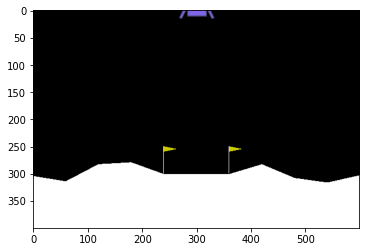

In [ ]:
env = gym.make('LunarLanderContinuous-v2')
env.reset()
plt.imshow(env.render('rgb_array'))

In [ ]:
env = wrap_env(env)
done = False
iter = 0
print(done)
state = env.reset()

action = 1
TotalReward = 0;
while not done:
  iter +=1
  action = env.action_space.sample()
  #print("action is:",action)
  observation, reward, done, _ = env.step(action)
  #print("state is:", observation)

  #if you want to see results on real-time 'open' the following 4 lines
  #screen = env.render(mode='rgb_array')
  #plt.imshow(screen)
  #ipythondisplay.clear_output(wait=True)
  #ipythondisplay.display(plt.gcf())
print(TotalReward)

False
0


In [ ]:
env.close()
show_video()

**This is an example of random run**
**We will see how our approaches improve upon this initial result.**



## **CONFIGURABLE MLP network**#

In [ ]:
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Beta, Normal
import math

import torch.nn.init as init

ACT2FN = {
    "relu": torch.nn.ReLU(),
    "tanh": torch.nn.Tanh(),
    "sigmoid": torch.nn.Sigmoid(),
    "leakyrelu": torch.nn.LeakyReLU(0.1),
    "softmax": torch.nn.Softmax()
}

DEFAULTS = {
    "bias": True,
    "activation": "relu",
    "dropout": None,
    "assign_dims": "exp",
    "pool_before": None,
    "layer_type": "linear",
    "kernel_assign_dims": "start_twice",
    "kernel": 3,
    "stride": 1,
    "padding": 1
}

def get_exponent_2_layers(initial_dim, final_dim, layer_count):
    in_dim = initial_dim
    dims = []
    for i in range(layer_count):
        if(i == layer_count - 1):
            next_dim = final_dim
        else:
            next_dim = int(in_dim/2)
        dims.append((in_dim, next_dim))
        in_dim = next_dim
    return dims

def get_alternating_dims(initial_dim, final_dim, layer_count):
    dims = []
    same_dim = True
    j = 0
    for i in range(layer_count):

        if(same_dim):
            cur_dim = initial_dim / 2**j
            cur_pair = (int(cur_dim), int(cur_dim))
        else:
            cur_dim = initial_dim / 2**j
            next_dim = initial_dim / 2**(j+1)
            cur_pair = (int(cur_dim), int(next_dim))
            j += 1

        dims.append(cur_pair)
        same_dim = not same_dim
    if(final_dim is None):
        return dims
    return dims + [(dims[-1][1], int(final_dim))]

def get_alternating_dims_reverse(initial_dim, final_dim, layer_count):
    dims = []
    same_dim = True
    j = 0
    for i in range(layer_count):

        if(same_dim):
            cur_dim = initial_dim * 2**j
            cur_pair = (int(cur_dim), int(cur_dim))
        else:
            cur_dim = initial_dim * 2**j
            next_dim = initial_dim * 2**(j+1)
            cur_pair = (int(cur_dim), int(next_dim))
            j += 1

        dims.append(cur_pair)
        same_dim = not same_dim
    if(final_dim is None):
        return dims
    return dims + [(dims[-1][1], int(final_dim))]

def list_to_pairs(values):
    return [(int(values[i]),int(values[i+1])) for i in range(len(values) - 1)]

def get_linear_layers(initial_dim, final_dim, layer_count):
    return list_to_pairs(list(np.array(np.linspace(initial_dim, final_dim,num=layer_count+1),dtype=int)))

def get_same_layers(initial_dim, final_dim, layer_count):
    return [(initial_dim,initial_dim) for _ in range(layer_count - 1)] + [(initial_dim, final_dim)]        


ASSIGN_LAYER_TO_DIM = {
    'exp': get_exponent_2_layers,
    'linear': get_linear_layers,
    'same': get_same_layers,
    "alt_same": get_alternating_dims,
    "alt_same_rev": get_alternating_dims_reverse
}

def start_twice(kernel, count):
    return [count] + [count - i for i in range(count)]

KERNEL_ASSIGN_LAYER_TO_DIM = {
    "start_twice": start_twice,
    "same": lambda kernel, count: [kernel] + [kernel for i in range(count)]
}

def create_config(input_dim, final_dim, start_dim, layer_count=2, layer_dims = None, bias=DEFAULTS['bias'], \
                  activation=DEFAULTS['activation'], dropout=DEFAULTS['dropout'], \
                  assign_dims = DEFAULTS["assign_dims"], layer_type=DEFAULTS["layer_type"], final_activation="tanh", kernel=DEFAULTS["kernel"], 
                  padding=DEFAULTS["padding"], stride=DEFAULTS["stride"], kernel_assign_dims = DEFAULTS["kernel_assign_dims"]):
    if(layer_dims is not None):
        layer_dims_pairs = list_to_pairs([str(input_dim)] + layer_dims.split(",") + [str(final_dim)])
    else:
        layer_dims_pairs = [(input_dim , start_dim)] + ASSIGN_LAYER_TO_DIM[assign_dims](start_dim, final_dim, layer_count)
    
    kernel_list = KERNEL_ASSIGN_LAYER_TO_DIM[kernel_assign_dims](kernel, layer_count)
    
    print(layer_dims_pairs)
    print(kernel_list)
    return [
        {
            "in_features": pair[0], 
            "out_features": pair[1], 
            "bias": bias if pair_index < len(layer_dims_pairs) - 1 else True ,  
            "activation": activation if pair_index < len(layer_dims_pairs) - 1 else final_activation , 
            "dropout": dropout if pair_index < len(layer_dims_pairs) - 1 else None,
            "layer_type": layer_type,
            "kernel": kernel_list[pair_index],
            "stride": stride,
            "padding": padding if pair_index < len(layer_dims_pairs) - 1 else 0,
        }
        for pair_index, pair in enumerate(layer_dims_pairs)
    ]    
    
class ConfigurableLayer(nn.Module):
    def __init__(self, in_features, out_features, bias=DEFAULTS['bias'], activation=DEFAULTS['activation'], \
                       dropout=DEFAULTS['dropout'], layer_type=DEFAULTS["layer_type"], kernel=DEFAULTS["kernel"], 
                       padding=DEFAULTS["padding"], stride=DEFAULTS["stride"]):
        super().__init__()
        self.layer_type = layer_type
        
        if(layer_type == "linear"):
            self.linear = nn.Linear(
                in_features = in_features,
                out_features = out_features,
                bias = bias,
            )
        
        if(layer_type == "conv1d"):
            self.linear = nn.Conv1d(
                in_features, 
                out_features, 
                kernel, 
                stride=stride, 
                padding=padding)
        
        self.activation = ACT2FN[activation] if activation is not None else None
        self.dropout = nn.Dropout(dropout) if (dropout is not None and dropout > 0) else None
    
        
    def forward(self, x):
        x = self.linear(x)
        if(self.activation is not None):
            x = self.activation(x)
        
        if(self.dropout is not None):
            return self.dropout(x)
        
        return x

class ConfigurableMLP(nn.Module):
    def __init__(self, layer_configs=None, detach=False):
        super().__init__()
        self.layers = nn.ModuleList(ConfigurableLayer(**layer_config) for layer_config in layer_configs)
        self.detach = detach
    
    def forward(self, x):
        if(self.detach):
            x = x.detach() # stop gradient BP to the hidden states
        
        for layer_index, layer in enumerate(self.layers):
            x = layer(x)
        return x
        
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__


#**PART 1**#
#**LunarLanderContinous with Discretisation of action space**#

##**DQN-DDQN**#
With velocities and without

[DQN code source](https://goodboychan.github.io/python/reinforcement_learning/pytorch/udacity/2021/05/07/DQN-LunarLander.html
)

In [ ]:
# https://notebooks.gesis.org/binder/jupyter/user/goodboychan-goo-ychan.github.io-d651542d/notebooks/_notebooks/2021-05-07-DQN-LunarLander.ipynb
# import wandb
import gym
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import base64, io
import argparse
import os
import uuid
import itertools
import numpy as np
from collections import deque, namedtuple

### Replay Memory

In [ ]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(self.device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(self.device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(self.device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(self.device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### Q-Networks

In [ ]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size,seed, hidden_dim=128, last_dim=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, last_dim)
        self.fc3 = nn.Linear(last_dim, action_size)
        
    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

DQN Agent

In [ ]:
class DQNAgent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, lr , seed=0, batch_size=32 ,buffer_size=int(1e5), gamma=0.99, TAU=1, is_ddqn=False,  hidden_dim=128, last_dim=128):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.batch_size = batch_size 
        self.buffer_size = buffer_size
        self.lr = lr
        self.UPDATE_EVERY = 50
        self.gamma = gamma
        self.TAU = TAU
        self.is_ddqn = is_ddqn
        self.hidden_dim = hidden_dim
        self.last_dim = last_dim

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed,hidden_dim=self.hidden_dim, last_dim=self.last_dim).to(self.device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed, hidden_dim=self.hidden_dim, last_dim=self.last_dim).to(self.device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=self.lr)

        # Replay memory
        self.memory = ReplayBuffer(action_size, self.buffer_size, self.batch_size, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % self.UPDATE_EVERY
        # if self.t_step == 0:

        # If enough samples are available in memory, get random subset and learn
        if len(self.memory) > self.batch_size:
            experiences = self.memory.sample()
            self.learn(experiences, self.gamma)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        # Obtain random minibatch of tuples from D
        states, actions, rewards, next_states, dones = experiences

        ## Compute and minimize the loss
        
        if self.is_ddqn:
            ### Extract next maximum estimated value from target network
            q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        else:
            q_targets_next = self.qnetwork_local(next_states).detach().max(1)[0].unsqueeze(1)

        ### Calculate target value from bellman equation
        q_targets = rewards + gamma * q_targets_next * (1 - dones)
        ### Calculate expected value from local network
        q_expected = self.qnetwork_local(states).gather(1, actions)
        
        ### Loss calculation (we used Mean squared error)
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        #--------------------       DDQN            ------------------- #
        if self.is_ddqn:
            self.hard_update(self.qnetwork_local, self.qnetwork_target)
        #self.soft_update(self.qnetwork_local, self.qnetwork_target, self.TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

    def hard_update(self, local_model, target_model):
        """Soft update model parameters.
        θ_target = θ_local if self.UPDATE_TARGET

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
        """
        if self.t_step == 0:
            for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
                target_param.data.copy_(local_param.data)

 **Evaluation**

In [ ]:
import numpy as np

def eval(env, discrete_actions, max_steps, agent, episodes, args, no_velocity=False, nb_runs = 100):
    print('------------------------------------------------------------------')
    print('---------------------------- EVALUATION --------------------------')
    print('------------------------------------------------------------------')
    rewards_100 = []
    for episode in range(1,nb_runs):
        state = env.reset()
        last_state = state
        episode_reward = 0
        episode_steps = 0
        for st in range(max_steps):
            if no_velocity:
                diff_x = state[0] - last_state[0]
                diff_y =  state[1] - last_state[1]
                state[2] = diff_x
                state[3] = diff_y
            action_index = agent.act(state, eps=0.)
            action = discrete_actions[action_index]
            # Recieve state and reward from environment.
            next_state, reward, done, info = env.step(action)
            #change original reward from -100 to -5 and 5*reward for other values
            episode_reward += reward
            episode_steps += 1
            last_state = state
            state = next_state
            if done:
                break;
        print(f"Episode: {episode}/100, score: {episode_reward}", end="\r")
        rewards_100.append(episode_reward)
    avg_runs = np.mean(rewards_100)
    return avg_runs

    # if avg_runs > 200:
    #     print(f'Environment solved in {episodes} episodes')
    #     print('Solved environment with Avg Score:  ', avg_runs)
    #     return True
    # else:
    #     print('NOT SOLVED')
    #     print(f'Environment not solved in {episodes} episodes')
    #     print('Avg Score:  ', avg_runs)
    #     return False

### DQN MAIN

In [ ]:
import numpy as np
def dqn(env, agent, discrete_actions, args, n_episodes=2000, max_steps=3000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, no_velocity=False):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    finished = False

    #os.environ["WANDB_API_KEY"] = "191df1de6e46bd994b2ffb092c9f287e7b89a301"

    args.name = str(uuid.uuid1()).split("-")[0]
    args.group_name = 'DDQN' if args.is_ddqn else 'DQN'
    if no_velocity:
        args.group_name = args.group_name + '_no_velocity'
    print(args.group_name)

    # wandb.init(
    #     project="LunarLander",
    #     group=args.group_name,
    #     name=args.name,
    #     dir="/tmp",
    # )
    # wandb.config.update(args) 

    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        last_state = state
        score = 0
        for t in range(max_steps):
            if no_velocity:
                diff_x = state[0] - last_state[0]
                diff_y =  state[1] - last_state[1]
                state[2] = diff_x
                state[3] = diff_y
            action_index = agent.act(state, eps)
            action = discrete_actions[action_index]
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action_index, reward, next_state, done)
            last_state = state
            state = next_state
            score += reward
            if done:
                print(f"Episode: {i_episode}/{n_episodes}, score: {score} , avg_score {np.mean(scores_window)}", end="\r")
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon

        # wandb.log({
        #     "episode": i_episode,
        #     "score": score,
        #     'max': max(scores)})
        

        if score>=200 or i_episode%100==0:
            print('\n')
            print(f'episode : {i_episode}')
            avg_runs = eval(env, discrete_actions, max_steps, agent, i_episode, args, no_velocity=no_velocity)

            # wandb.log({'avg_100 :': avg_runs})

            if avg_runs > 200:
              print(f'Environment solved in {i_episode} episodes')
              print('Solved environment with Avg Score:  ', avg_runs)
              print('\n')
              finished = True
            else:
              print('NOT SOLVED')
              print(f'Environment not solved in {i_episode} episodes')
              print('Avg Score:  ', avg_runs)
              print('\n')
              finished = False



            if finished:
                if args.is_ddqn:
                    directory = 'checkpoint/ddqn'
                else:
                    directory = 'checkpoint/dqn'
                if no_velocity:
                    directory = os.path.join(directory,'no_velocity')
                if not os.path.isdir(directory):
                    os.makedirs(directory)
                torch.save(agent.qnetwork_local.state_dict(), os.path.join(directory,f'solved_{args.name}_{i_episode}.pth'))
                break

        # #print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        # if i_episode % 100 == 0:
        #     print()
        #     print('\rEpisode {} \t Average Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        # if np.mean(scores_window)>=200.0:
        #     print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
        #     torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
        #     break
    # env.close()
    # if finished:
    #   show_video()
    return scores, finished

def run(discrete_actions, game, args):
    env = gym.make(game)
    # env = wrap_env(env)
    state_size = env.observation_space.shape[0]
    action_size = len(discrete_actions)
    agent = DQNAgent(state_size, action_size, is_ddqn=args.is_ddqn, lr=args.lr , seed=args.seed, batch_size=args.batch_size ,buffer_size=args.buffer_size, gamma=args.gamma, hidden_dim=args.hidden_dim, last_dim=args.last_dim)#, TAU=args.TAU)
    scores ,finished = dqn(env, agent, discrete_actions, args, n_episodes=args.episodes, max_steps=3000, no_velocity=args.no_velocity)
    env.close()
    return scores, finished , agent
    


How many episodes we would like to run for

In [ ]:
ddqn_episodes = 1500

In [ ]:
args = {
  'gamma':0.99,
  'epsilon':0.9,
  'episodes': ddqn_episodes, 
  'seed':1, 
  'lr':0.0005,
  'batch_size':64, 
  'buffer_size':int(1e5), 
  'is_ddqn':True, 
  'target_update':50, 
  'hidden_dim':128, 
  'last_dim':128,
  'group_name':"DDQN", 
  'no_velocity': False
}
args = dotdict(args)
game = 'LunarLanderContinuous-v2'
#before add to args
# main_egine_actions = [-1.0, 0.33, 0.66, 1.0]
# left_right_actions = [-1, -0.75, 0, 0.75, 1]

### DDQN with Velocities

In [ ]:
args.episodes

30

In [ ]:
main_egine_actions = [0, 0.5, 1.0]
left_right_actions = [-1, -0.75, 0, 0.75, 1]

discrete_actions = list(itertools.product(main_egine_actions, left_right_actions))
scores, finished, agent = run(discrete_actions, game, args)


DDQN


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
from logging import StringTemplateStyle
env = gym.make(game)

env = wrap_env(env)
done = False
iter = 0
state = env.reset()
last_state = state

action = 1
TotalReward = 0;
while not done:
  iter +=1
  if args.no_velocity:
    diff_x = state[0] - last_state[0]
    diff_y =  state[1] - last_state[1]
    state[2] = diff_x
    state[3] = diff_y
  action_index = agent.act(state, eps=0.)
  action = discrete_actions[action_index]
  #print("action is:",action)
  next_state, reward, done, _ = env.step(action)
  last_state = state
  state = next_state
  #print("state is:", observation)

  #if you want to see results on real-time 'open' the following 4 lines
  # screen = env.render(mode='rgb_array')
  # plt.imshow(screen)
  # ipythondisplay.clear_output(wait=True)
  # ipythondisplay.display(plt.gcf())
print(TotalReward)
  

0


In [ ]:
env.close()
show_video()

Graph

In [ ]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### DDQN without velocities

In [ ]:
args = {
  'gamma':0.99,
  'epsilon':0.9,
  'episodes':ddqn_episodes, 
  'seed':1, 
  'lr':0.0005,
  'batch_size':64, 
  'buffer_size':int(1e6), 
  'is_ddqn':True, 
  'target_update':50, 
  'hidden_dim':256, 
  'last_dim':256,
  'group_name':"DDQN", 
  'no_velocity': True
}
args = dotdict(args)
game = 'LunarLanderContinuous-v2'
#before add to args
main_egine_actions = [0, 0.5, 1.0]
left_right_actions = [-1, -0.75, 0, 0.75, 1]

In [ ]:
discrete_actions = list(itertools.product(main_egine_actions, left_right_actions))
scores, finished, agent = run(discrete_actions, game, args)

DDQN_no_velocity


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
from logging import StringTemplateStyle
env = gym.make(game)

print(args.no_velocity)
env = wrap_env(env)
done = False
iter = 0
state = env.reset()
last_state = state

action = 1
TotalReward = 0;
while not done:
  iter +=1
  if args.no_velocity:
    diff_x = state[0] - last_state[0]
    diff_y =  state[1] - last_state[1]
    state[2] = diff_x
    state[3] = diff_y
  action_index = agent.act(state, eps=0.)
  action = discrete_actions[action_index]
  #print("action is:",action)
  next_state, reward, done, _ = env.step(action)
  last_state = state
  state = next_state
  #print("state is:", observation)

  #if you want to see results on real-time 'open' the following 4 lines
  # screen = env.render(mode='rgb_array')
  # plt.imshow(screen)
  # ipythondisplay.clear_output(wait=True)
  # ipythondisplay.display(plt.gcf())
print(TotalReward)
  

True
0


In [ ]:
env.close()
show_video()


In [ ]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### DQN with velocities

In [ ]:
args = {
  'gamma':0.99,
  'epsilon':0.9,
  'episodes':ddqn_episodes, 
  'seed':1, 
  'lr':0.0005,
  'batch_size':64, 
  'buffer_size':int(1e5), 
  'is_ddqn':False, 
  'target_update':50, 
  'hidden_dim':64, 
  'last_dim':64,
  'group_name':"DQN", 
  'no_velocity': False
}
args = dotdict(args)
game = 'LunarLanderContinuous-v2'
#before add to args
# main_egine_actions = [-1.0, 0.33, 0.66, 1.0]
# left_right_actions = [-1, -0.75, 0, 0.75, 1]

In [ ]:
main_egine_actions = [0, 0.5, 1.0]
left_right_actions = [-1, -0.75, 0, 0.75, 1]

discrete_actions = list(itertools.product(main_egine_actions, left_right_actions))
scores, finished, agent = run(discrete_actions, game, args)

DQN


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
from logging import StringTemplateStyle
env = gym.make(game)


env = wrap_env(env)
done = False
iter = 0
state = env.reset()
last_state = state

action = 1
TotalReward = 0;
while not done:
  iter +=1
  if args.no_velocity:
    diff_x = state[0] - last_state[0]
    diff_y =  state[1] - last_state[1]
    state[2] = diff_x
    state[3] = diff_y
  action_index = agent.act(state, eps=0.)
  action = discrete_actions[action_index]
  #print("action is:",action)
  next_state, reward, done, _ = env.step(action)
  last_state = state
  state = next_state
  #print("state is:", observation)

  #if you want to see results on real-time 'open' the following 4 lines
  # screen = env.render(mode='rgb_array')
  # plt.imshow(screen)
  # ipythondisplay.clear_output(wait=True)
  # ipythondisplay.display(plt.gcf())
print(TotalReward)
  

0


In [ ]:
env.close()
show_video()

In [ ]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### DQN without velocities

In [ ]:
args = {
  'gamma':0.99,
  'epsilon':0.9,
  'episodes':ddqn_episodes, 
  'seed':1, 
  'lr':0.0005,
  'batch_size':64, 
  'buffer_size':int(1e6), 
  'is_ddqn':False, 
  'target_update':50, 
  'hidden_dim':128, 
  'last_dim':128,
  'group_name':"DQN", 
  'no_velocity': True
}
args = dotdict(args)
game = 'LunarLanderContinuous-v2'
#before add to args
main_egine_actions = [0, 0.5, 1.0]
left_right_actions = [-1, -0.75, 0, 0.75, 1]

In [ ]:
discrete_actions = list(itertools.product(main_egine_actions, left_right_actions))
scores, finished, agent = run(discrete_actions, game, args)

DQN_no_velocity


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
from logging import StringTemplateStyle
env = gym.make(game)

env = wrap_env(env)
done = False
iter = 0
state = env.reset()
last_state = state

action = 1
TotalReward = 0;
while not done:
  iter +=1
  if args.no_velocity:
    diff_x = state[0] - last_state[0]
    diff_y =  state[1] - last_state[1]
    state[2] = diff_x
    state[3] = diff_y
  action_index = agent.act(state, eps=0.)
  action = discrete_actions[action_index]
  #print("action is:",action)
  next_state, reward, done, _ = env.step(action)
  last_state = state
  state = next_state
  #print("state is:", observation)

  #if you want to see results on real-time 'open' the following 4 lines
  # screen = env.render(mode='rgb_array')
  # plt.imshow(screen)
  # ipythondisplay.clear_output(wait=True)
  # ipythondisplay.display(plt.gcf())
print(TotalReward)


0


In [ ]:
env.close()
show_video()


In [ ]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## **TD3-Fork**
code from https://github.com/honghaow/FORK/tree/master/TD3-FORK

paper https://arxiv.org/abs/2010.01652

### Model-Networks

In [ ]:
## import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, seed, args, fc_units=400, fc1_units=300):
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        # self.fc1 = nn.Linear(state_size, fc_units)
        # self.fc2 = nn.Linear(fc_units, fc1_units)
        # self.fc3 = nn.Linear(fc1_units, action_size)
        config = create_config(state_dim,
                            action_dim,
                            start_dim=args.start_dim,
                            layer_count=args.layer_count,
                            layer_dims = args.layer_dims,
                            bias=True,
                            activation=args.activation,
                            dropout=args.dropout,
                            assign_dims = args.assign_dims,
                            layer_type=args.layer_type,
                            final_activation=args.final_activation,
                            kernel=args.kernel,
                            stride=args.stride,
                            padding=args.padding,
                            kernel_assign_dims=args.kernel_assign_dims)
        self.mlp = ConfigurableMLP(config)
        print(f"actor: {self}")

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        # x = F.relu(self.fc1(state))
        # x = F.relu(self.fc2(x))
        # return F.torch.tanh(self.fc3(x))
        return self.mlp(state)

# Q1-Q2-Critic Neural Network  
  
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, seed, args, fc1_units=400, fc2_units=300):
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        config = create_config(state_dim + action_dim,
                                1,
                                start_dim=args.critic_start_dim,
                                layer_count=args.critic_layer_count,
                                layer_dims=args.critic_layer_dims,
                                bias=True,
                                activation=args.critic_activation,
                                dropout=args.critic_dropout,
                                assign_dims=args.critic_assign_dims,
                                layer_type=args.critic_layer_type,
                                final_activation=args.critic_final_activation,
                                kernel=args.critic_kernel,
                                stride=args.critic_stride,
                                padding=args.critic_padding,
                                kernel_assign_dims=args.critic_kernel_assign_dims)
        

        # Q1 architecture
        # self.l1 = nn.Linear(state_size + action_size, fc1_units)
        # self.l2 = nn.Linear(fc1_units, fc2_units)
        # self.l3 = nn.Linear(fc2_units, 1)
        self.q1_mlp = ConfigurableMLP(config)

        # Q2 architecture
        self.q2_mlp = ConfigurableMLP(config)
        # self.l4 = nn.Linear(state_size + action_size, fc1_units)
        # self.l5 = nn.Linear(fc1_units, fc2_units)
        # self.l6 = nn.Linear(fc2_units, 1)
        print(f"critic: {self}")

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xa = torch.cat([state, action], 1)

        # x1 = F.relu(self.l1(xa))
        # x1 = F.relu(self.l2(x1))
        # x1 = self.l3(x1)
        x1 = self.q1_mlp(xa)

        # x2 = F.relu(self.l4(xa))
        # x2 = F.relu(self.l5(x2))
        # x2 = self.l6(x2)
        x2 = self.q2_mlp(xa)

        return x1, x2


class SysModel(nn.Module):
    def __init__(self, state_dim, action_dim, args, fc1_units=400, fc2_units=300):
        super(SysModel, self).__init__()
        # self.l1 = nn.Linear(state_size + action_size, fc1_units)
        # self.l2 = nn.Linear(fc1_units, fc2_units)
        # self.l3 = nn.Linear(fc2_units, state_size)
        config = create_config(state_dim + action_dim,
                                state_dim,
                                start_dim=args.critic_start_dim,
                                layer_count=args.critic_layer_count,
                                layer_dims=args.critic_layer_dims,
                                bias=True,
                                activation=args.critic_activation,
                                dropout=args.critic_dropout,
                                assign_dims=args.critic_assign_dims,
                                layer_type=args.critic_layer_type,
                                final_activation=args.critic_final_activation,
                                kernel=args.critic_kernel,
                                stride=args.critic_stride,
                                padding=args.critic_padding,
                                kernel_assign_dims=args.critic_kernel_assign_dims)
        self.mlp = ConfigurableMLP(config)
        print(f"sys: {self}")


    def forward(self, state, action):
        """Build a system model to predict the next state at a given state."""
        xa = torch.cat([state, action], 1)

        # x1 = F.relu(self.l1(xa))
        # x1 = F.relu(self.l2(x1))
        # x1 = self.l3(x1)
        x1 = self.mlp(xa)

        return x1

class CONV1D(nn.Module):
    def __init__(self, config_conv, config_mlp):
        super().__init__()
        self.conv = ConfigurableMLP(config_conv)
        self.mlp = ConfigurableMLP(config_mlp)
#         self.final_activation = None if final_activation is None else ACT2FN[final_activation]
        
    def forward(self, x, action):
        out = self.conv(x.permute(0,2,1))
        mat = out.mean(dim=2)
        
        sa = torch.cat([mat, action], 1)
        
        out = self.mlp(sa)
        return out
    

class Sys_R(nn.Module):
    def __init__(self,state_dim, action_dim, args):
        super(Sys_R, self).__init__()

        # Q1 architecture
        # self.l1 = nn.Linear(2 * state_dim + action_dim, fc1_units)
        # self.l2 = nn.Linear(fc1_units,fc2_units)
        # self.l3 = nn.Linear(fc2_units, 1)
        def create_mlp_model():
            config = create_config(2*state_dim + action_dim, 1, start_dim = args.reward_start_dim, layer_count=args.reward_layer_count, layer_dims = args.reward_layer_dims, bias=True, \
                    activation=args.reward_activation, dropout=args.reward_dropout, \
                    assign_dims = args.reward_assign_dims, layer_type="linear", final_activation=args.reward_final_activation)
                    
            return ConfigurableMLP(config)
        
        def create_conv1d():
            config_conv = create_config(state_dim, state_dim, start_dim = args.reward_start_dim, layer_count=args.reward_layer_count, layer_dims = args.reward_layer_dims, bias=True, \
                  activation=args.reward_activation, dropout=args.reward_dropout, \
                  assign_dims = args.reward_assign_dims, layer_type="conv1d", final_activation=args.reward_final_activation, kernel=args.reward_kernel, stride=args.reward_stride, padding=args.reward_padding, kernel_assign_dims=args.reward_kernel_assign_dims)
            
            config_mlp = create_config(state_dim + action_dim, 1, start_dim = args.reward_start_dim, layer_count=args.reward_layer_count, layer_dims = args.reward_layer_dims, bias=True, \
                    activation=args.reward_activation, dropout=args.reward_dropout, \
                    assign_dims = args.reward_assign_dims, layer_type="linear", final_activation=args.reward_final_activation)
                    
        
            return CONV1D(config_conv=config_conv, config_mlp=config_mlp)

        MODEL_CASES = {
            "linear": create_mlp_model,
            "conv1d": create_conv1d
        }
        self.reward_layer_type = args.reward_layer_type
        self.mlp = MODEL_CASES[args.reward_layer_type]()
        print(f"reward: {self}")


    def forward(self, state, next_state, action):
        if(self.reward_layer_type == "linear"):
            sa = torch.cat([state,next_state, action], 1)

            # q1 = F.relu(self.l1(sa))
            # q1 = F.relu(self.l2(q1))
            # q1 = self.l3(q1)
            r = self.mlp(sa)
        else:
            state_stack = torch.stack([state,next_state], dim=1)
            r = self.mlp(state_stack, action)

        return r

### TD3 Fork

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
import random
from collections import deque


class TD3_FORK:
    def __init__(self,
        ## self,name,env,self,
        env,
        args,
        load = False,
        gamma = 0.99, #discount factor
        lr = 3e-4,
        batch_size = 100,
        buffer_capacity = 1000000,
        tau = 0.02,  #target network update factor
        random_seed = np.random.randint(1,10000),
        cuda = True,
        policy_noise=0.2, 
        std_noise = 0.1,
        noise_clip=0.5,
        policy_freq=2 #target network update period
    ):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.env = env
        self.args = args
        
        self.actor_loss_2_step_weight = args.actor_loss_2_step_weight 
        self.action_dim_to_use = self.env.action_space.shape[0] if self.args.discrete_setup is None else len(args.discrete_setup_combs)
        self.create_actor(args)
        self.create_critic(args)
        self.create_sysmodel(args)
        
        self.act_opt = optim.Adam(self.actor.parameters(), lr=lr)
        self.crt_opt = optim.Adam(self.critic.parameters(), lr=lr)
        self.sys_opt = optim.Adam(self.sysmodel.parameters(), lr=lr)

        if(args.use_reward_model):
            self.create_sysr(args)
            self.sys_r_opt = optim.Adam(self.sysr.parameters(), lr=lr)

        self.replay_memory_buffer = deque(maxlen = buffer_capacity)
        self.replay_memory_bufferd_dis = deque(maxlen = buffer_capacity)
        self.batch_size = batch_size
        self.tau = tau
        self.policy_freq = policy_freq
        self.gamma = gamma
##      self.name = name
        self.upper_bound = self.env.action_space.high[0] #action space upper bound
        self.lower_bound = self.env.action_space.low[0]  #action space lower bound
        self.obs_upper_bound = self.env.observation_space.high[0] #state space upper bound
        self.obs_lower_bound = self.env.observation_space.low[0]  #state space lower bound
        self.policy_noise = policy_noise
        self.noise_clip = noise_clip
        self.std_noise = std_noise   
 

    

    def create_actor(self, args):
        params = {
            'state_dim':      self.env.observation_space.shape[0],
            'action_dim':     self.action_dim_to_use,
            'seed':            88,
            'args':            args
        }
        self.actor = Actor(**params).to(self.device)
        self.actor_target = Actor(**params).to(self.device)

    def create_critic(self, args):
        params = {
            'state_dim':      self.env.observation_space.shape[0],
            'action_dim':     self.action_dim_to_use,
            'seed':            88,
            'args':            args
        }
        self.critic = Critic(**params).to(self.device)
        self.critic_target = Critic(**params).to(self.device)

    def create_sysmodel(self, args):
        params = {
            'state_dim':      self.env.observation_space.shape[0],
            'action_dim':     self.action_dim_to_use,
            'args':            args
        }
        self.sysmodel = SysModel(**params).to(self.device)

    def create_sysr(self, args):
        params = {
            'state_dim':      self.env.observation_space.shape[0],
            'action_dim':     self.action_dim_to_use,
            'args':            args
        }
        self.sysr = Sys_R(**params).to(self.device)


    def add_to_replay_memory(self, transition, buffername):
        #add samples to replay memory
        buffername.append(transition)

    def get_random_sample_from_replay_mem(self, buffername):
        #random samples from replay memory
        random_sample = random.sample(buffername, self.batch_size)
        return random_sample


    def learn_and_update_weights_by_replay(self,training_iterations, weight, totrain):
        """Update policy and value parameters using given batch of experience tuples.
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        """
        # print(len(self.replay_memory_buffer))
        if len(self.replay_memory_buffer) < 1e4:
            return 1
        for it in range(training_iterations):
            mini_batch = self.get_random_sample_from_replay_mem(self.replay_memory_buffer)
            state_batch = torch.from_numpy(np.vstack([i[0] for i in mini_batch])).float().to(self.device)
            action_batch = torch.from_numpy(np.vstack([i[1] for i in mini_batch])).float().to(self.device)
            reward_batch = torch.from_numpy(np.vstack([i[2] for i in mini_batch])).float().to(self.device)
            next_state_batch = torch.from_numpy(np.vstack([i[4] for i in mini_batch])).float().to(self.device)
            done_list = torch.from_numpy(np.vstack([i[5] for i in mini_batch]).astype(np.uint8)).float().to(self.device)

            # Training and updating Actor & Critic networks.
            
            #Train Critic
            target_actions = self.actor_target(next_state_batch)
            
            if(self.args.discrete_setup is None):
                offset_noises = torch.FloatTensor(action_batch.shape).data.normal_(0, self.policy_noise).to(self.device)

                #clip noise
                offset_noises = offset_noises.clamp(-self.noise_clip, self.noise_clip)
                target_actions = (target_actions + offset_noises).clamp(self.lower_bound, self.upper_bound)

            #Compute the target Q value
            Q_targets1, Q_targets2 = self.critic_target(next_state_batch, target_actions)
            Q_targets = torch.min(Q_targets1, Q_targets2)
            Q_targets = reward_batch + self.gamma * Q_targets * (1 - done_list)

            #Compute current Q estimates
            current_Q1, current_Q2 = self.critic(state_batch, action_batch)
            # Compute critic loss
            critic_loss = F.mse_loss(current_Q1, Q_targets.detach()) + F.mse_loss(current_Q2, Q_targets.detach())
            # Optimize the critic
            self.crt_opt.zero_grad()
            critic_loss.backward()
            self.crt_opt.step()

            self.soft_update_target(self.critic, self.critic_target)


            #Train_sysmodel
            predict_next_state = self.sysmodel(state_batch, action_batch) * (1-done_list)
            next_state_batch = next_state_batch * (1 -done_list)
            sysmodel_loss = F.mse_loss(predict_next_state, next_state_batch.detach())
            self.sys_opt.zero_grad()
            sysmodel_loss.backward()
            self.sys_opt.step()
            
            if(self.args.use_reward_model):
                # Train reward model
                predict_reward = self.sysr(state_batch, next_state_batch, action_batch)
                sysr_loss = F.mse_loss(predict_reward, reward_batch.detach())
                self.sys_r_opt.zero_grad()
                sysr_loss.backward()
                self.sys_r_opt.step()

        
            s_flag = 1 if sysmodel_loss.item() < 0.020  else 0

            #Train Actor
            # Delayed policy updates
            if it % self.policy_freq == 0 and totrain == 1:
                actions = self.actor(state_batch)
                actor_loss1,_ = self.critic_target(state_batch, actions)
                actor_loss1 =  actor_loss1.mean()
                actor_loss =  - actor_loss1 

                if s_flag == 1:
                    p_actions = self.actor(state_batch)
                    p_next_state = self.sysmodel(state_batch, p_actions).clamp(self.obs_lower_bound,self.obs_upper_bound)

                    p_actions2 = self.actor(p_next_state.detach()) * self.upper_bound

                    if(self.args.use_reward_model):
                        p_next_r = self.sysr(state_batch,p_next_state.detach(),self.actor(state_batch))

                    actor_loss2,_ = self.critic_target(p_next_state.detach(), p_actions2)
                    actor_loss2 = actor_loss2.mean() 

                    p_next_state2= self.sysmodel(p_next_state.detach(), p_actions2).clamp(self.obs_lower_bound,self.obs_upper_bound)

                    if(self.args.use_reward_model):
                        p_next_r2 = self.sysr(p_next_state.detach(),p_next_state2.detach(),self.actor(p_next_state.detach()))

                    p_actions3 = self.actor(p_next_state2.detach()) * self.upper_bound
                    actor_loss3,_ = self.critic_target(p_next_state2.detach(), p_actions3)
                    
                    if(self.args.use_reward_model):
                        actor_loss3 = actor_loss3 - (weight * p_next_r + weight * self.gamma * p_next_r2).mean()

                    actor_loss3 = actor_loss3.mean() 

                    actor_loss_final =  actor_loss - weight * (actor_loss2) - self.actor_loss_2_step_weight *  weight * actor_loss3
                else:
                    actor_loss_final =  actor_loss

                self.act_opt.zero_grad()
                actor_loss_final.backward()
                self.act_opt.step()

                #Soft update target models
               
                self.soft_update_target(self.actor, self.actor_target)
                
        return sysmodel_loss.item()

    def soft_update_target(self,local_model,target_model):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(self.tau*local_param.data + (1.0-self.tau)*target_param.data)

    def policy(self,state):
        """select action based on ACTOR"""
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        self.actor.eval()
        with torch.no_grad():
            actions = self.actor(state).cpu().data.numpy()
        self.actor.train()
        
        if(self.args.discrete_setup is not None):
            return np.squeeze(from_disc_to_cont(self.args, actions)), np.squeeze(actions) 
        
        # Adding noise to action
        shift_action = np.random.normal(0, self.std_noise, size=self.env.action_space.shape[0])
        sampled_actions = (actions + shift_action)
        # We make sure action is within bounds
        legal_action = np.clip(sampled_actions,self.lower_bound,self.upper_bound)
        output = np.squeeze(legal_action)
        return output, output


    def select_action(self,state):
        """select action based on ACTOR"""
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        with torch.no_grad():
            actions = self.actor_target(state).cpu().data.numpy()
            
        if(self.args.discrete_setup is not None):
            return np.squeeze(from_disc_to_cont(self.args, actions))
        
        return np.squeeze(actions)

    
def from_disc_to_cont(args, action):
    arg_max = action.argmax(axis=1)
    assert arg_max.shape[0] == action.shape[0]
    transformed_action = args.discrete_setup_combs[arg_max]
    return transformed_action

In [ ]:
import numpy as np

import torch
## import torch.nn as nn
import torch.nn.functional as F
import gym
from collections import deque
import random
import matplotlib.pyplot as plt

import time
from itertools import product

import matplotlib.pyplot as plt
import os
import argparse
import uuid

def main(args):
    env_name = args.env_name#'BipedalWalkerHardcore-v3'
    args.env_name = env_name
    env = gym.make(env_name)
    agent = TD3_FORK(env, args, batch_size=args.batch_size, gamma=args.gamma, lr=args.lr)

    threshold = env.spec.reward_threshold
    max_steps = env._max_episode_steps
    print(' threshold: ', threshold, ', max_steps: ', max_steps)

    start_timestep=10000 # it was 0            #time_step to select action based on Actor
    scores_array, avg_scores_array, avg_numm_steps_array, finished, agent, full_eval_scores = td3_fork_train(args, agent, env, max_steps, start_timestep,threshold, total_episodes=args.total_episodes)
    return scores_array, avg_scores_array, avg_numm_steps_array, finished, agent, full_eval_scores
    # print('length of scores: ', len(scores), ', len of avg_scores: ', len(avg_scores))




# save(agent = agent, filename='checkpnt, directory = 'dir_chkpoint')     
def save(agent, directory, filename, episode, reward):
    if not os.path.isdir(directory):
        os.mkdir(directory)
    torch.save(agent.actor.state_dict(), '%s/%s_actor_%s_%s.pth' % (directory, filename, episode, reward))
    torch.save(agent.critic.state_dict(), '%s/%s_critic_%s_%s.pth' % (directory, filename, episode, reward))
    torch.save(agent.sysmodel.state_dict(), '%s/%s_sysmodel_%s_%s.pth' % (directory, filename, episode, reward))
    torch.save(agent.actor_target.state_dict(), '%s/%s_actor_target_%s_%s.pth' % (directory, filename, episode, reward))
    torch.save(agent.critic_target.state_dict(), '%s/%s_critic_target_%s_%s.pth' % (directory, filename, episode, reward))

def td3_fork_train(args, agent, env, max_steps, start_timestep, threshold, total_episodes=40000):
    
    scores_deque = deque(maxlen=100)
    scores_array = []
    avg_scores_array = [] 
    num_steps_deque = deque(maxlen=100)
    avg_numm_steps_array = []
    full_eval_scores = []
    
    total_timesteps = 0
    sys_loss = 0
    expcount = 0
    totrain = 0
    falling_down = 0
    do_eval = 0
    finished = False

    time_start = time.time()                   # Init start time

    args.name = str(uuid.uuid1()).split("-")[0]
    # os.environ["WANDB_API_KEY"] = args.wandb_api_key
    
    # wandb.init(
    #     project=args.project_name,
    #     group=args.group_name,
    #     name=args.name,
    #     dir="/tmp",
    # )
    # wandb.config.update(args) 
    
#     print("do first eval")
#     avg_reward_from_full = eval_policy(agent, args.env_name, eval_episodes=100)
    max_avg_reward_from_full = 0
    for i_episode in range(total_episodes):
        print(f"In episode {i_episode}")
        state = env.reset()
        last_state = state
        episode_reward = 0
        episode_steps = 0
        timestep = 0
        temp_replay_buffer = []

        for st in range(max_steps):
            if(bool(args.no_veloc)):
                diffx = state[0] - last_state[0]
                diffy = state[1] - last_state[1]
                state[2] = diffx
                state[3] = diffy
            # Select action randomly or according to policy
            if total_timesteps < start_timestep:
                if(args.discrete_setup is not None):
                    random_action_index = np.random.randint(0,len(args.discrete_setup_combs))
                    action = args.discrete_setup_combs[random_action_index]
                    action_to_insert = args.index_to_vec[random_action_index]
                else:
                    action = env.action_space.sample()
                    action_to_insert = action
            else:
                ## std_noice is moved into agent.policy
                action, action_to_insert = agent.policy(state)

            # Recieve state and reward from environment.
            next_state, reward, done, info = env.step(action)
            #change original reward from -100 to -5 and 5*reward for other values
            episode_reward += reward
            episode_steps += 1

            if(bool(args.fall_reward_condition)):
                reward_trick_condition = reward == -100
            else:
                reward_trick_condition = reward <= -100
                
            if reward_trick_condition:
                add_reward = args.fall_reward_add
                reward = args.fall_reward_set
                falling_down += 1
                expcount += 1
            else:
                add_reward = 0
                reward = args.non_fall_reward_mult * reward

            temp_replay_buffer.append((state, action_to_insert, reward, add_reward, next_state, done))
            
            # End this episode when `done` is True
            if done:
                if add_reward == args.fall_reward_add or episode_reward < 250:            
                    totrain = 1
                    for temp in temp_replay_buffer: 
                        agent.add_to_replay_memory(temp, agent.replay_memory_buffer)
                        
                    if (add_reward == args.fall_reward_add and args.falling_repeat_states > 0):
                        for _ in range(args.falling_repeat_states):
                            for temp in temp_replay_buffer: 
                                agent.add_to_replay_memory(temp, agent.replay_memory_buffer)
                        
                elif expcount > 0 and np.random.rand() > 0.5:
                    totrain = 1
                    expcount -= 10
                    for temp in temp_replay_buffer: 
                        agent.add_to_replay_memory(temp, agent.replay_memory_buffer)
                break
            last_state = state
            state = next_state
            
            timestep += 1     
            total_timesteps += 1
        
        scores_deque.append(episode_reward)
        scores_array.append(episode_reward)        
        avg_score = np.mean(scores_deque)
        avg_scores_array.append(avg_score)
        
        num_steps_deque.append(episode_steps)
        avg_num_steps = np.mean(num_steps_deque)
        avg_numm_steps_array.append(avg_num_steps)


        #Training agent only when new experiences are added to the replay buffer
        weight =  1 - np.clip(avg_score/300, 0, 1)
        if totrain == 1:
            sys_loss = agent.learn_and_update_weights_by_replay(timestep, weight, totrain)
        else: 
            sys_loss = agent.learn_and_update_weights_by_replay(100, weight, totrain)
        totrain = 0

        # wandb.log({
        #     "episode": i_episode,
        #     "score": episode_reward,
        #     'max': max(scores_array),
        #     'average_last_100': avg_score
        # })

        if i_episode % 500 == 0 and i_episode > 0:
            reward_round = round(episode_reward, 2)
            save(agent, f'dir_bpw_td3_fork_{args.name}', 'weights', str(i_episode), str(reward_round))
        
        if i_episode % 10 == 0 and i_episode > 0:  

            s = (int)(time.time() - time_start)
            min_score = np.min(scores_deque)
            max_score = np.max(scores_deque)
            med_score = np.median(scores_deque)
            print("Ep.: {}, Avg.Num.St.: {:.1f}, Min-Max.Sc.: ({:.2f}, {:.2f}), Med.Sc.:{:.3f}, Avg.Sc.: {:.3f}, Time: {:02}:{:02}:{:02}, F.D.: {}, weight: {:.3f}".\
                format(i_episode, avg_num_steps, min_score, max_score, med_score, avg_score, \
                  s//3600, s%3600//60, s%60, falling_down, weight ))
            
        if(i_episode % args.full_eval_freq == 0):
            print("DOING FULL EVAL")
            avg_reward_from_full = eval_policy(agent, args.env_name, eval_episodes=100, args=args)
            full_eval_scores.append({
                'avg_reward_from_full':avg_reward_from_full,
                'episode': i_episode
            })
            print(f"FULL EVAL RES: max_avg_reward_from_full: {max_avg_reward_from_full}, avg_reward_from_full: {avg_reward_from_full}")
            if avg_reward_from_full >= env.spec.reward_threshold:
              print(f'Environment solved in {i_episode} episodes')
              print('Solved environment with Avg Score:  ', avg_reward_from_full)
              print('\n')
              finished = True
              break
            else:
              print('NOT SOLVED')
              print(f'Environment not solved in {i_episode} episodes')
              print('Avg Score:  ', avg_reward_from_full)
              print('\n')
              finished = False



            if(max_avg_reward_from_full < avg_reward_from_full):
                max_avg_reward_from_full = avg_reward_from_full
                save(agent, f'dir_bpw_td3_fork_FULL_{args.name}', 'weights', str(i_episode), str(avg_reward_from_full))
                print(f"SAVED AT {i_episode}")
            
            
    return scores_array, avg_scores_array, avg_numm_steps_array, finished, agent, full_eval_scores


def eval_policy(agent, env_name, eval_episodes, args):
    eval_env = gym.make(env_name)
    avg_reward = 0.
    for _ in range(eval_episodes):
        state, done = eval_env.reset(), False
        last_state = state
        while not done:
            if(bool(args.no_veloc)):
                diffx = state[0] - last_state[0]
                diffy = state[1] - last_state[1]
                state[2] = diffx
                state[3] = diffy
            action, _ = agent.policy(state)
            next_state, reward, done, _ = eval_env.step(action)
            
            last_state = state
            state = next_state
            avg_reward += reward

    avg_reward /= eval_episodes
    print("---------------------------------------")
    print(f"Evaluation over {eval_episodes} episodes: {avg_reward}")
    print("---------------------------------------")
    # wandb.log({
    #     "avg_reward": avg_reward
    # })
    eval_env.close()
    return avg_reward


def get_combs_from_setup(discrete_setup):
    discrete_setup_list = [np.array([float(y) for y in x.split(",")]) for x in discrete_setup.split("_")]
    combs = np.array(list(product(*[v for v in discrete_setup_list])))
    
    return combs, np.identity(len(combs))


def run_td3_fork(env_name, discrete_setup, no_veloc, total_episodes, full_eval_freq):
  args = {
    'gamma':0.99,
    'net_width':300, 
    'lr':4e-4, 
    'batch_size':200,
    'group_name':"td3_fork",
    'use_reward_model':0, 
    # 'wandb_api_key':"",
    'total_episodes': total_episodes,
    'full_eval_freq':full_eval_freq, 

    'env_name': env_name, #"BipedalWalkerHardcore-v3",
    'discrete_setup':discrete_setup,
    'project_name':"rein_bipedal", 

    'fall_reward_condition':1,
    'fall_reward_add':-1, 
    'fall_reward_set':-5, 
    'non_fall_reward_mult':5, 
    'falling_repeat_states':0,

    'start_dim':300, 
    'activation':"relu", 
    'dropout':0.0, 
    'final_activation':"tanh", 
    'assign_dims':'same',
    'layer_count':2, 
    'layer_dims':None, 

    'kernel':2,  
    'stride':1, 
    'padding':1, 
    'kernel_assign_dims':"same", 
    'layer_type':"linear", 

    'critic_start_dim':300, 
    'critic_activation':"relu", 
    'critic_dropout':0.0, 
    'critic_final_activation':None,
    'critic_assign_dims':"same", 
    'critic_layer_count':2,
    'critic_layer_dims':None,
    'critic_kernel':3, 
    'critic_stride':1, 
    'critic_padding':1, 
    'critic_kernel_assign_dims':"same",
    'critic_layer_type':"linear", 
    'reward_start_dim':300, 
    'reward_activation':"relu", 
    'reward_dropout':0.0, 
    'reward_final_activation':None, 
    'reward_assign_dims':"same",
    'reward_layer_count':2, 
    'reward_layer_dims':None, 
    'reward_kernel':2, 
    'reward_stride':1, 
    'reward_padding':1, 
    'reward_kernel_assign_dims':"same", 
    'reward_layer_type':"linear", 
    'seed':1,
    'actor_loss_2_step_weight':0.5, 
    'no_veloc':no_veloc
  } 

  args = dotdict(args)

  if(args.discrete_setup is not None):
      print(f"args.discrete_setup: {args.discrete_setup}")
      args.discrete_setup_combs, args.index_to_vec = get_combs_from_setup(args.discrete_setup)
      print(f"args.discrete_setup_combs: {args.discrete_setup_combs}, {args.discrete_setup_combs.dtype}")
      print(f"args.index_to_vec: {args.index_to_vec}, {args.index_to_vec.dtype}")
  seed=args.seed
  torch.manual_seed(seed)
  scores, avg_scores, avg_numm_steps ,finished, agent, full_eval_scores = main(args)
  return scores, avg_scores, avg_numm_steps ,finished, agent, full_eval_scores

td3f_lunar_episodes: how many episodes should td3 fork lunar environment run

td3f_eval_freq : how often should full evaluation run 

In [ ]:
td3f_lunar_episodes = 1500
td3f_eval_freq = 100

In [ ]:
from logging import StringTemplateStyle
import matplotlib.pyplot as plt
import pandas as pd
import torch

# td3_fork_total_episodes = 30
# full_eval_freq = 10


def get_video(env, agent):
  done = False
  iter = 0
  state = env.reset()
  last_state = state

  action = 1
  TotalReward = 0;
  while not done:
    iter +=1
    if agent.args.no_veloc:
      diff_x = state[0] - last_state[0]
      diff_y =  state[1] - last_state[1]
      state[2] = diff_x
      state[3] = diff_y
    action, _ = agent.policy(state)
    #print("action is:",action)
    next_state, reward, done, _ = env.step(action)
    last_state = state
    state = next_state
    #print("state is:", observation)

    #if you want to see results on real-time 'open' the following 4 lines
    # screen = env.render(mode='rgb_array')
    # plt.imshow(screen)
    # ipythondisplay.clear_output(wait=True)
    # ipythondisplay.display(plt.gcf())
  print(TotalReward)


def show_graphs(scores, full_avg_scores):
    plt.plot(range(len(scores)), scores)
    plt.xlabel("Episode")
    plt.ylabel("Score")
    plt.title("Training Score vs Training Episode")
    plt.show()

    full_avg_scores_pd = pd.DataFrame(full_avg_scores)
    plt.plot(full_avg_scores_pd['episode'], full_avg_scores_pd['avg_reward_from_full'])
    plt.xlabel("Episode")
    plt.ylabel("Mean Reward")
    plt.title("Full 100-episode Eval Reward vs Training Episode")
    plt.show()



### RUN with velocity

In [ ]:
def run_with_velocity(td3_fork_total_episodes, full_eval_freq):
  return run_td3_fork(
      env_name = "LunarLanderContinuous-v2", 
      discrete_setup = "0,0.5,1_-1,-0.75,0,0.75,1", 
      no_veloc = 0,
      total_episodes = td3_fork_total_episodes,
      full_eval_freq = full_eval_freq
  )

disc_veloc_scores, disc_veloc_avg_scores, disc_veloc_avg_numm_steps , disc_veloc_finished, disc_veloc_agent, disc_veloc_full_eval_scores = run_with_velocity(td3f_lunar_episodes, td3f_eval_freq)

In [ ]:
show_graphs(disc_veloc_scores, disc_veloc_full_eval_scores)

In [ ]:
env = gym.make("LunarLanderContinuous-v2")
env = wrap_env(env)
get_video(env, disc_veloc_agent)
env.close()
show_video()

0


### RUN *without* velocity

In [ ]:
def run_without_velocity(td3_fork_total_episodes, full_eval_freq):
  return run_td3_fork(
      env_name = "LunarLanderContinuous-v2", 
      discrete_setup = "0,0.5,1_-1,-0.75,0,0.75,1", 
      no_veloc = 1,
      total_episodes = td3_fork_total_episodes,
      full_eval_freq = full_eval_freq
  )

disc_NO_veloc_scores, disc_NO_veloc_avg_scores, disc_NO_veloc_avg_numm_steps, disc_NO_veloc_finished, disc_NO_veloc_agent, disc_NO_veloc_full_eval_scores = run_without_velocity(td3f_lunar_episodes, td3f_eval_freq)

In [ ]:
show_graphs(disc_NO_veloc_scores, disc_NO_veloc_full_eval_scores)

In [ ]:
env = gym.make("LunarLanderContinuous-v2")
env = wrap_env(env)
get_video(env, disc_NO_veloc_agent)
env.close()
show_video()

0


#**PART 2**#

**We try different models: DQN, DDQN, SAC , TD3**

**But only TD3-Fork get good results**

## Run TD3-Fork






td3f_bipedal_episodes: how many episodes should td3 fork lunar environment run

td3f_bipedal_eval_freq : how often should full evaluation run

In [ ]:
td3f_bipedal_episodes = 3000
td3f_bipedal_eval_freq = 100

In [ ]:
def run_hardcore(td3_fork_total_episodes, full_eval_freq):
  return run_td3_fork(
      env_name = "BipedalWalkerHardcore-v3", 
      discrete_setup = None, 
      no_veloc = 0,
      total_episodes = td3_fork_total_episodes,
      full_eval_freq = full_eval_freq
  )

hard_scores, hard_avg_scores, hard_avg_numm_steps, hard_finished, hard_agent, hard_full_eval_scores = run_hardcore(td3f_bipedal_episodes, td3f_bipedal_eval_freq)

In [ ]:
show_graphs(hard_scores, hard_full_eval_scores)

In [ ]:
env = gym.make("BipedalWalkerHardcore-v3")
env = wrap_env(env)
get_video(env, hard_agent)
env.close()
show_video()

0
